In [2]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Flatten, Input 
from sklearn.model_selection import train_test_split

# Sequential model 

In [2]:
seq_model = tf.keras.models.Sequential([
                                        tf.keras.layers.Flatten(input_shape=(28, 28)),
                                        tf.keras.layers.Dense(units=128, activation='relu'),
                                        tf.keras.layers.Dense(units=10, activation='softmax')
])

# Functional model

#### Defining the input

In [3]:
input = tf.keras.layers.Input(shape=(28, 28))

#### Defining the layers

In [9]:
x = tf.keras.layers.Flatten()(input)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
predictions = tf.keras.layers.Dense(units=10, activation='softmax')(x)

#### Defining the model 

In [11]:
func_model = tf.keras.models.Model(inputs=input, outputs=predictions)

#### Plot the model

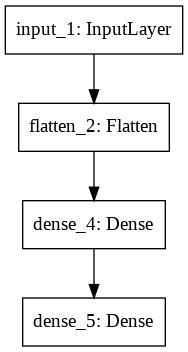

In [13]:
tf.python.keras.utils.vis_utils.plot_model(model=func_model, show_layer_names=True)

#### Train the model 

In [15]:
# prepare fashion mnist dataset 
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images = training_images / 255.0
test_images = test_images / 255.0

# configure, train, and evaluate the model
func_model.compile(optimizer=tf.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
func_model.fit(training_images, training_labels, epochs=5)
func_model.evaluate(test_images, test_labels)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5004 - accuracy: 0.8242
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3807 - accuracy: 0.8638
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3396 - accuracy: 0.8768
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3146 - accuracy: 0.8844
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3670 - accuracy: 0.8695


[0.36701953411102295, 0.8694999814033508]

# Multi output model

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [3]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [4]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [5]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
_______________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [6]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [7]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 0s 7ms/step - loss: 221.2983 - y1_output_loss: 109.5113 - y2_output_loss: 111.7869 - y1_output_root_mean_squared_error: 10.4648 - y2_output_root_mean_squared_error: 10.5729 - val_loss: 37.5228 - val_y1_output_loss: 12.9229 - val_y2_output_loss: 24.5999 - val_y1_output_root_mean_squared_error: 3.5948 - val_y2_output_root_mean_squared_error: 4.9598
Epoch 2/500
62/62 [==============================] - 0s 4ms/step - loss: 30.3554 - y1_output_loss: 12.4586 - y2_output_loss: 17.8967 - y1_output_root_mean_squared_error: 3.5297 - y2_output_root_mean_squared_error: 4.2305 - val_loss: 73.9092 - val_y1_output_loss: 22.0653 - val_y2_output_loss: 51.8439 - val_y1_output_root_mean_squared_error: 4.6974 - val_y2_output_root_mean_squared_error: 7.2003
Epoch 3/500
62/62 [==============================] - 0s 4ms/step - loss: 28.7000 - y1_output_loss: 10.7440 - y2_output_loss: 17.9560 - y1_output_root_mean_squared_error: 3.2778 - y2_output_root_mean_sq

## Evaluate the Model and Plot Metrics

In [8]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 1.1254 - y1_output_loss: 0.2388 - y2_output_loss: 0.8867 - y1_output_root_mean_squared_error: 0.4886 - y2_output_root_mean_squared_error: 0.9416
Loss = 1.1254220008850098, Y1_loss = 0.2387528419494629, Y1_mse = 0.48862341046333313, Y2_loss = 0.8866690993309021, Y2_mse = 0.9416310787200928


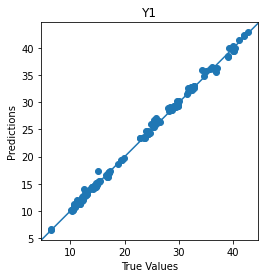

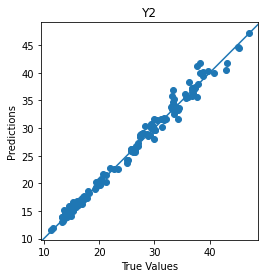

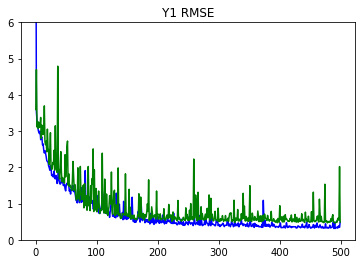

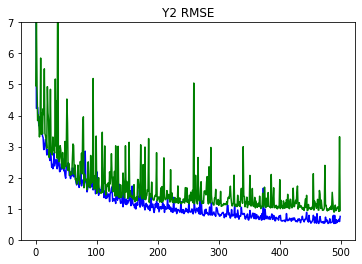

In [9]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)